based on this [tutorial](https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb#scrollTo=TG4ub4Qf0T78)

# Download data

In [1]:
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/
    !ls

In [2]:
# !unzip "/content/drive/MyDrive/DL project/data.zip"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Image

import glob
import os

from PIL import Image
from torchvision.datasets import Places365

cuda = torch.cuda.is_available()
# device = torch.device("cuda:0" if cuda else "cpu")
device = "cpu"
# Define the train and test sets
dset  = Places365(root= os.getcwd() + '/data', split = 'val', small = True, download = False)

8000 2000


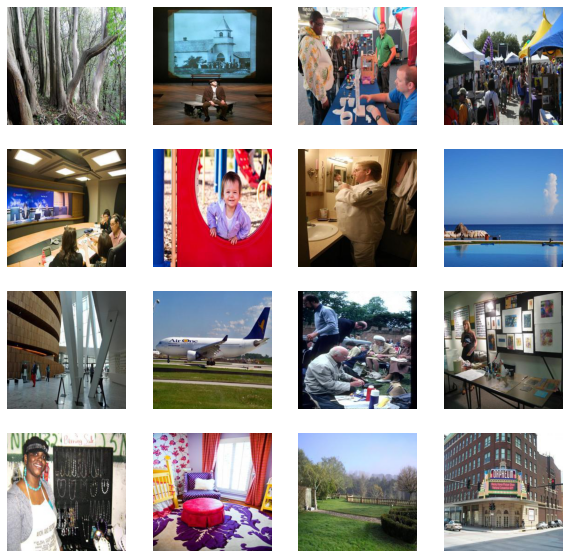

In [4]:
path = os.getcwd()
paths = glob.glob(path + os.sep + "data" +os.sep+"val_256_NOBW"+os.sep+"*.jpg")
# Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [5]:
len(paths)

32509

In [6]:
from utils import make_dataloaders

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [7]:
abs_.shape # [batch, channels, [shape]]

torch.Size([16, 2, 256, 256])

## D

In [8]:
from nets import PatchDiscriminator
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

## utils

In [9]:
from utils import lab_to_rgb, lab_to_BW
from nets import MainModel

# Evaluation


In [10]:
#load model and data
from eval import PSNR, colourfulnessMetric
from torchvision.models.vgg import vgg19
from nets import build_vgg_unet, build_timm_unet
import pandas as pd

eval_paths = glob.glob(path + os.sep + "data" + os.sep+"val_split" + os.sep + "*.jpg")

paths_subset = list(np.random.choice(eval_paths, 10, replace=False))  # for test
eval_dl = make_dataloaders(paths=paths_subset, split='val',batch_size=1, mode='standard')
eval_dlX = make_dataloaders(paths=paths_subset, split='val',batch_size=1, mode='xception')
eval_dl = list(iter(eval_dl))
eval_dlX = list(iter(eval_dlX))
# make list, otherwise it will be exhausted and the loop cannot work

modelL1 = MainModel(loss='L1')
checkpointL1 = torch.load("models/model_epoch_100.pt", map_location=device)
modelL1.load_state_dict(checkpointL1['model_state_dict'])

modelL2 = MainModel(loss='L2')
checkpointL2 = torch.load("models/model_L2_epoch_100.pt", map_location=device)
modelL2.load_state_dict(checkpointL2['model_state_dict'])

net_GX = build_timm_unet('xception')
checkpoint_GX = torch.load("models/backbone_xception_epoch_100.pt", map_location=device)
xception = MainModel(net_G=net_GX)
xception.load_state_dict(checkpoint_GX['model_state_dict'])

net_G = build_vgg_unet(vgg19)
checkpoint_V = torch.load("models/backbone_vgg_epoch_100.pt", map_location=device)
vgg = MainModel(net_G=net_G)
vgg.load_state_dict(checkpoint_V['model_state_dict'])

models = {"L1": modelL1, "L2": modelL2, "xception": xception, "vgg": vgg}

model initialized with norm initialization
model initialized with norm initialization
model initialized with norm initialization
model initialized with norm initialization
model initialized with norm initialization


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\andre/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:50<00:00, 11.3MB/s]


model initialized with norm initialization


In [11]:
def eval_model(model, dataloader=eval_dl):
    colourfulnesses_ref = np.zeros(len(dataloader))
    PSNRs = np.zeros(len(dataloader))
    colourfulnesses = np.zeros(len(dataloader))
    model.net_G.eval()
    for i, eval_img in enumerate(dataloader):
        with torch.no_grad():
            model.setup_input(eval_img) 
            model.forward()
        fake_color = model.fake_color.detach()
        real_color = model.ab
        L = model.L
        fake_img = lab_to_rgb(L, fake_color)[0, :,:,:]
        real_img = lab_to_rgb(L, real_color)[0, :,:,:]

        PSNRs[i] = PSNR(real_img, fake_img)
        colourfulnesses[i] = colourfulnessMetric(fake_img) 
        colourfulnesses_ref[i] = colourfulnessMetric(real_img)
    return PSNRs, colourfulnesses, colourfulnesses_ref

res = np.zeros((4,4))
for i, key in enumerate(models):
    print(key)
    if key == 'xception':
        PSNRs, colourfulnesses, colourfulnesses_ref = eval_model(models[key], dataloader=eval_dlX)
    else:
        PSNRs, colourfulnesses, colourfulnesses_ref= eval_model(models[key], dataloader=eval_dl)
    res[i, :] = np.mean(PSNRs), np.mean(colourfulnesses), np.mean(colourfulnesses_ref), np.mean(colourfulnesses) - np.mean(colourfulnesses_ref)

results = pd.DataFrame(data=res, columns=['PSNR','Colourfulness', 'Reference colourfulness', 'Difference'])
results.index = ['BaselineL1', "BaselineL2", 'Xception backbone', 'VGG19 backbone']
results

L1
L2
xception
vgg


,PSNR,Colourfulness,Reference colourfulness,Difference
BaselineL1,30.207894,31.396571,37.395923,-5.999353
BaselineL2,29.948969,33.902347,37.395923,-3.493576
Xception backbone,30.264100,33.875427,37.395923,-3.520496
VGG19 backbone,29.753072,22.737780,37.395923,-14.658144


## Let's look at the least and most colourful

In [19]:
min_col = np.min(colourfulnesses)
min_col_idx = np.argmin(colourfulnesses)
print(min_col, min_col_idx)
max_col = np.max(colourfulnesses)
max_col_idx = np.argmax(colourfulnesses)
max_col, max_col_idx

17.00535421813894 6


(31.8662730867797, 2)

In [15]:
categories = pd.read_csv("data/categories_places365.txt", sep=" ", header=None)
# from no. to category
n_to_cat = dict(zip(categories[1], categories[0]))
labels = pd.read_csv("data/places365_val.txt", sep=" ", header=None)
fname_to_n = dict(zip(labels[0], labels[1]))

def cat_from_filename(path):
    path = path.split(os.sep)[-1]
    return n_to_cat[fname_to_n[path]]

top5_max_colourful = np.argsort(colourfulnesses)[-5:]
top5_min_colourful = np.argsort(colourfulnesses)[:5]

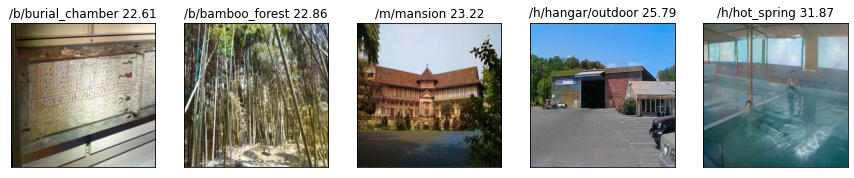

In [18]:
# most colourful predicted
model = models['xception']
fig, ax = plt.subplots(1,5, figsize=(15,5))
for i, item in enumerate(top5_max_colourful):
    with torch.no_grad():
        model.setup_input(eval_dlX[item]) 
        model.forward()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_img = lab_to_rgb(L, fake_color)[0, :,:,:]
    ax[i].imshow(fake_img)
    ax[i].set_title(cat_from_filename(paths_subset[item]) + f' {colourfulnesses[item]:.2f}')
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

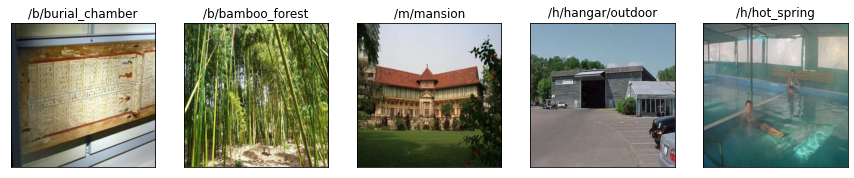

In [19]:
# most colourful (ground truth)
fig, ax = plt.subplots(1,5, figsize=(15,5))
for i, item in enumerate(top5_max_colourful):
    ax[i].imshow(Image.open(paths_subset[item]))
    ax[i].set_title(cat_from_filename(paths_subset[item]))
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

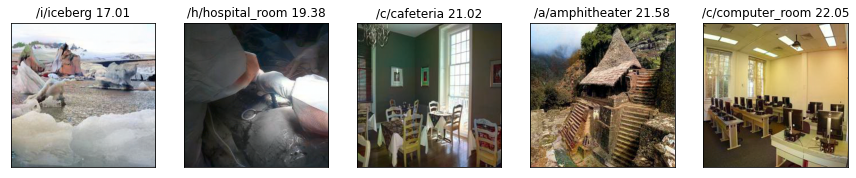

In [21]:
# least colourful predicted
fig, ax = plt.subplots(1,5, figsize=(15,5))
for i, item in enumerate(top5_min_colourful):
    with torch.no_grad():
        model.setup_input(eval_dlX[item]) 
        model.forward()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_img = lab_to_rgb(L, fake_color)[0, :,:,:]
    ax[i].imshow(fake_img)
    ax[i].set_title(cat_from_filename(paths_subset[item]) + f' {colourfulnesses[item]:.2f}')
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

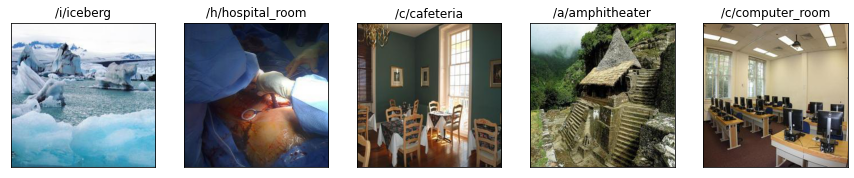

In [22]:
# least colourful (ground truth)
fig, ax = plt.subplots(1,5, figsize=(15,5))
for i, item in enumerate(top5_min_colourful):
    ax[i].imshow(Image.open(paths_subset[item]))
    ax[i].set_title(cat_from_filename(paths_subset[item]))
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

## Qualitative evaluation

* model 1 = baseline L1 loss
* model 2 = baseline L2 loss
* model 3 = Xception backbone
* model 4 = VGG backbone


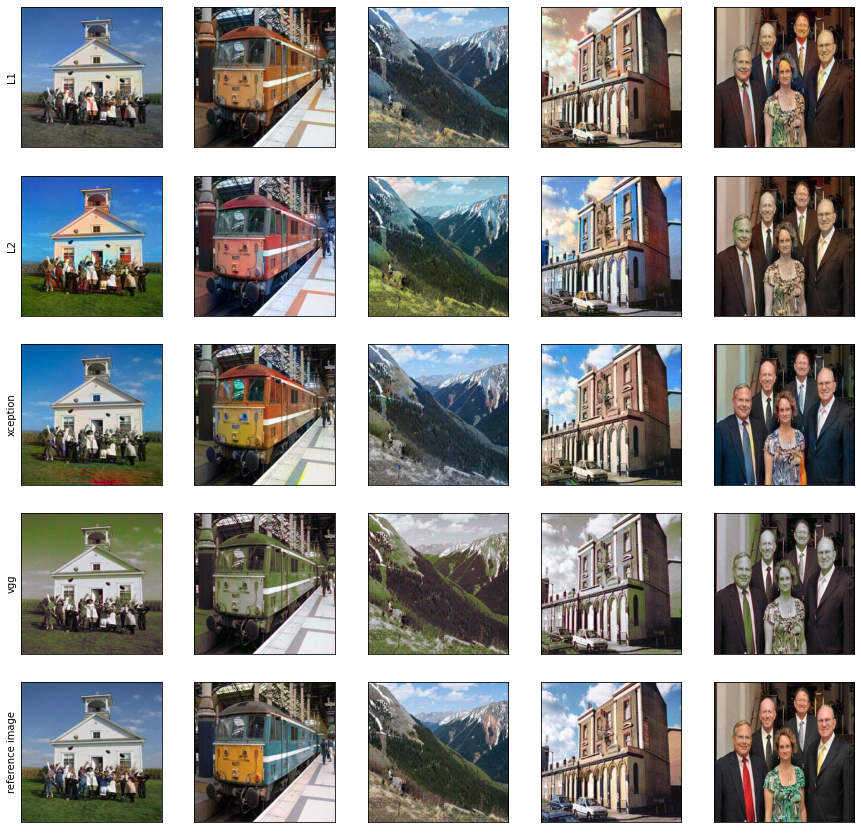

In [29]:
n_pics = 5
np.random.seed(1342)
cherry_path = glob.glob(path + os.sep + "figs" + os.sep+"cherry_picked" + os.sep + "*.jpg")
paths_subset = list(np.random.choice(cherry_path, n_pics, replace=False))
# i dont know how to use batches, so I just set it to 1.
eval_dl = make_dataloaders(paths=paths_subset, split='val',batch_size=1, mode='standard')
eval_dlX = make_dataloaders(paths=paths_subset, split='val',batch_size=1, mode='xception')
eval_dl = list(iter(eval_dl))
eval_dlX = list(iter(eval_dlX))

fig, axs = plt.subplots(len(models)+1, n_pics, figsize=(15,15))

for i, key in enumerate(models.keys()):
    model = models[key]
    model.eval()
    if key == "xception":
        dl = eval_dlX
    else:
        dl = eval_dl
    for j, eval_img in enumerate(dl):
        with torch.no_grad():
            model.setup_input(eval_img) 
            model.forward()
        fake_color = model.fake_color.detach()
        real_color = model.ab
        L = model.L
        fake_img = lab_to_rgb(L, fake_color)[0, :,:,:]
        real_img = lab_to_rgb(L, real_color)[0, :,:,:]
        axs[i, j].imshow(fake_img)
        if j%n_pics == 0:
            axs[i, j].set_ylabel(key)
            axs[len(models), j].set_ylabel('reference image')
        # disabling ticks by setting ticks to an empty list
        axs[i, j].set_xticks([])  
        axs[i, j].set_yticks([])

        axs[len(models), j].imshow(real_img)
        axs[len(models), j].set_xticks([])  
        axs[len(models), j].set_yticks([])
plt.savefig("figs/preds.png",dpi=300)

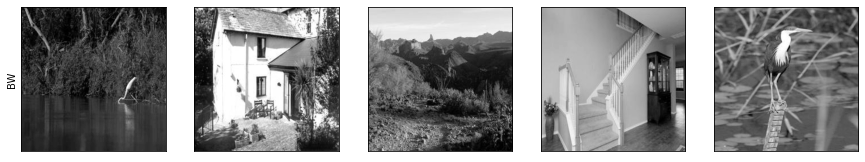

In [41]:
#reference
fig, axs = plt.subplots(1, n_pics, figsize=(15,5))
refs = ['BW']
for i, eval_img in enumerate(eval_dl):
    L, ab = eval_img['L'], eval_img['ab']
    fake_img = lab_to_BW(L)
    axs[i].imshow(fake_img,cmap='gray')
    if i%n_pics == 0:
        axs[i].set_ylabel(refs[0])
    # disabling ticks by setting ticks to an empty list
    axs[i].set_xticks([])  
    axs[i].set_yticks([])
plt.savefig("figs/preds_BW.png",dpi=300)    